In [284]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.special import softmax

In [285]:
from sklearn.cluster import AgglomerativeClustering

In [382]:
def metric_by_radius(y_true, y_pred, r):
    
    true_positives = 0  # they are true, and we chosen them
    false_negatives = 0 # they are true, but we haven't chosen them
    false_positives = 0  # they are false, but we chosen them

    indices_good = set()

    for i in range(len(y_true)):
        dist = np.linalg.norm(y_pred - y_true[i], axis=1)


        true_positives += int(len(dist[dist <= r]) > 0)


        cur_true_indices = np.where(dist <= r)[0]
        if len(cur_true_indices) > 0:
            indices_good.update([cur_true_indices[0]])
        else:
            false_negatives += 1


    false_positives = len(y_pred) - len(indices_good)
    # false_positives_arr = np.delete(y_pred, list(indices_good), axis=0)

    return true_positives, false_positives, false_negatives#, false_positives_arr

In [287]:
# y_pred.shape, len(y_pred)

In [288]:
def get_prob_of_dipole(output_arr_1, batch_number):
    one_pred = []
    # for key in example.keys():
    one_pred.append(output_arr_1[batch_number, 0])
    one_pred.append(output_arr_1[batch_number, 1])

    one_pred = np.array(one_pred)
    one_pred = np.transpose(one_pred, (1,2,3,0))
    proba_one = softmax(one_pred, axis=3)

    return proba_one[:, :, :, 1]


def output_to_coords(array, threshold):
    array = array.squeeze()

    return np.array(np.where(array.squeeze() > threshold)).T

In [307]:
batch_number = 0

def load_output(path, do_print=False):

    output = np.load(path)
    # output_0, output_1, output_2 = output['arr_0'], output['arr_1'], output['arr_2']

    y_pred = get_prob_of_dipole(output['arr_1'], batch_number)
    y_true = output['arr_2'][batch_number].squeeze()

    if do_print:
        print(y_true.shape, np.min(y_true), np.max(y_true), np.mean(y_true))
        print(y_pred.shape, np.min(y_pred), np.max(y_pred), np.mean(y_pred))

    y_true = output_to_coords(y_true, 0.5)
    y_pred = output_to_coords(y_pred, 0.6)

    if do_print:
        print(y_true.shape, np.min(y_true), np.max(y_true), np.mean(y_true))
        print(y_pred.shape, np.min(y_pred), np.max(y_pred), np.mean(y_pred))

    return y_true, y_pred

In [355]:

def metric(output_path, rng):

    result = []
    for r in tqdm(np.arange(0, rng)):

        y_true, y_pred = load_output(output_path)


        ac = AgglomerativeClustering(n_clusters=None, distance_threshold=r)
        y_pred_clusters = ac.fit_predict(y_pred,)

        temp = []
        for cluster_n in range(max(y_pred_clusters)):
            temp.append(y_pred[y_pred_clusters == cluster_n].mean(axis=0))

        y_pred = np.array(temp)

        r_result = metric_by_radius(y_true, y_pred, r)
        result.append(r_result)
        # result.append(list(r_result) + [r_result[0] + r_result[1], max(y_pred_clusters)])

    return np.array(result)

In [378]:
def f1_r(tp, fp, fn, r):
    f1_score = tp / (tp + 1/2*(fp + fn))

    plt.plot(r, f1_score, marker='o')
    plt.xlabel('radius')
    plt.ylabel('f1 score')

array([[   2, 1562,  321],
       [  16, 1548,  307],
       [  32,  870,  291],
       [  47,  530,  276],
       [  60,  376,  263],
       [  77,  279,  246],
       [  90,  218,  233],
       [ 104,  175,  219],
       [ 114,  149,  209],
       [ 131,  124,  192]])

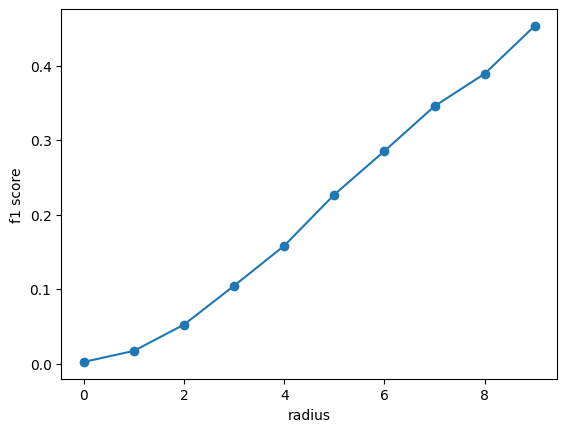

In [383]:
# (tp, fp, fn)
rgn = 10
m = metric('results/aug_none_49_epoch/test_7_pred.npz', rgn)
f1_r(*m.T, np.arange(rgn))
m

array([[   2, 1562,  321],
       [  16, 1548,  307],
       [  32,  869,  291],
       [  47,  529,  276],
       [  60,  371,  263],
       [  77,  266,  246],
       [  90,  189,  233],
       [ 104,  133,  219],
       [ 114,   89,  209],
       [ 131,   52,  192]])

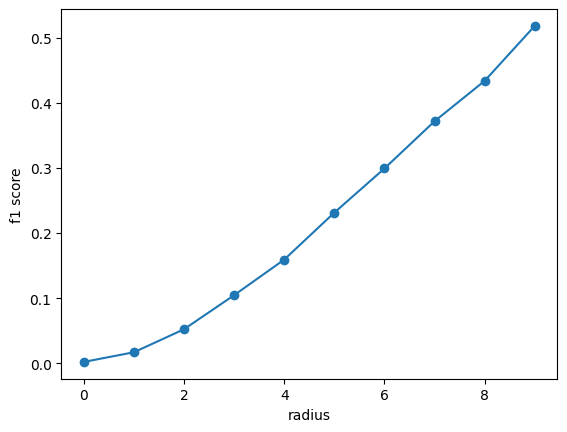

In [381]:
# (tp, fp, fn)
rgn = 10
m = metric('results/aug_none_49_epoch/test_7_pred.npz', rgn)
f1_r(*m.T, np.arange(rgn))
m

In [359]:
m.shape

(10, 3)

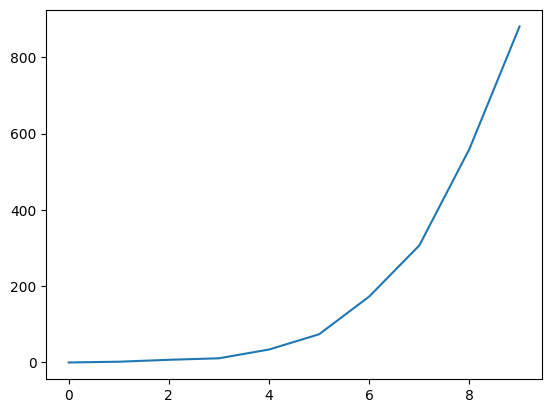

In [345]:
%matplotlib inline
from scipy.spatial.distance import cdist
dist_matrix = cdist(y_true, y_true) + np.triu([1]*len(y_true)) * 99999

dm_flatten = dist_matrix.flatten()

res = []
for d in np.arange(10):

    res.append(len(dm_flatten[dm_flatten <= d]))

plt.plot(np.arange(10), res)
x

In [ ]:
%matplotlib qt
ax = plt.subplot(111, projection='3d')

ax.scatter(*y_true.T, c='blue', alpha=1)
ax.scatter(*y_pred.T, c='red', alpha=1)

In [ ]:
%matplotlib qt
ax = plt.subplot(111, projection='3d')

_, _, false_pos = metric_by_radius(y_true, y_pred, 2)

ax.scatter(*y_true.T, c='blue', alpha=1)
ax.scatter(*y_pred[false_pos].T, c='red', alpha=1)

In [ ]:
false_pos.shape

(1468, 3)